In [1]:
## This is a test file to train to track an object
## Author : Avadesh Meduri
## Date : 8/04/2022

from matplotlib import pyplot as plt
import numpy as np

from torch.utils.data import Dataset
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision.io import read_image
from torch.utils.data import DataLoader, RandomSampler, Sampler
import time
from PIL import Image
from skimage.io import imread
import numba
from torchvision.transforms import ToTensor, ToPILImage, Resize
from IPython.display import display, clear_output

In [2]:
class BoxDataSet(Dataset):
    
    def __init__(self, fnames, mean = None, std = None, rgbd = True, resize = (224,224)):
        
        self.rgbd = rgbd
        self.resize = resize
        self.y_len = [0]
        self.img_dir = []
        for i in range(len(fnames)):
            self.img_dir.append("./image_data/data" + str(fnames[i]))
            self.data = np.load("./position_data/data" + str(fnames[i]) + ".npz")
            if i == 0:
                self.y_train = torch.tensor(self.data["position"]).float()
                self.y_len.append(len(self.data["position"])-1)
                
            else:
                self.y_train = torch.vstack((self.y_train, torch.tensor(self.data["position"]).float()))
                self.y_len.append(self.y_len[-1] + len(self.data["position"]))
        
        if isinstance(mean, np.ndarray) and isinstance(std, np.ndarray):
            print("using given mean")
            self.mean = mean
            self.std = std
            self.y_train = (self.y_train - self.mean)/self.std
        else:
            self.mean = torch.mean(self.y_train, axis = 0)
            self.std = torch.std(self.y_train, axis = 0)
            print(self.mean, self.std)
            self.y_train = (self.y_train - self.mean)/self.std
    
    def __len__(self):
        return int(len(self.y_train))
    
    def __getitem__(self, gidx):
        
        
        b_idx = max(np.searchsorted(self.y_len, gidx)-1,0) # which dir to look into
        idx = max(gidx - self.y_len[b_idx] - 1,0) # relative idx
        
        image = ToTensor()(imread(self.img_dir[b_idx] + "/color_" + str(idx) + ".jpg"))
        if self.rgbd:
            d_image = ToTensor()(imread(self.img_dir[b_idx] + "/depth_" + str(idx) + ".jpg"))
            image = torch.vstack((image, d_image))
            image = transforms.functional.crop(image,  50, 100, 180, 180)
        else:
            image = transforms.functional.crop(image,  50, 100, 180, 180)
            image = transforms.Resize(self.resize)(image)       
        
        label = self.y_train[gidx]
        
        return image.float(), label
                
    
    def get_data(self, gidx):
        
        
        b_idx = max(np.searchsorted(self.y_len, gidx)-1,0) # which dir to look into
        idx = max(gidx - self.y_len[b_idx] - 1,0) # relative idx
        
#         print(type(imread(self.img_dir[b_idx] + "/color_" + str(idx) + ".jpg")))
        image = ToTensor()(imread(self.img_dir[b_idx] + "/color_" + str(idx) + ".jpg"))
        if self.rgbd:
            d_image = ToTensor()(imread(self.img_dir[b_idx] + "/depth_" + str(idx) + ".jpg"))
            image = torch.vstack((image, d_image))
            image = transforms.functional.crop(image,  50, 100, 180, 180)

        else:
            image = transforms.functional.crop(image,  50, 100, 180, 180)
            image = transforms.Resize(self.resize)(image)                    

        label = self.y_train[gidx]
        
        return image.float()[None,:,:,:], label




tensor([0.2265, 0.0907, 0.4523]) tensor([0.0922, 0.2040, 0.1272])
tensor([ 1.0150,  0.7658, -0.6427])


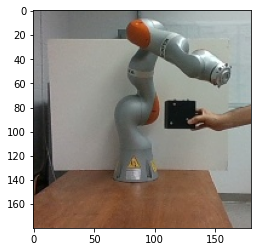

In [23]:
dl = BoxDataSet([15], rgbd = True, resize = (224,224))
image, label = dl.get_data(np.random.randint(10000))
box = ToPILImage()(image[0][0:3])
print(label)
plt.imshow(box)

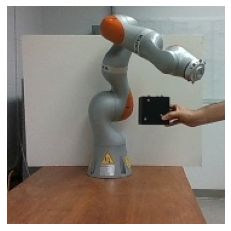

In [24]:
plt.axis('off')
plt.imshow(box)

In [4]:
class C_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv11 = nn.Conv2d(4, 64, 3)
        self.conv12 = nn.Conv2d(64, 64, 3)

        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv21 = nn.Conv2d(64, 128, 3)
        self.conv22 = nn.Conv2d(128, 128, 3)

        self.conv31 = nn.Conv2d(128, 256, 3)
        self.conv32 = nn.Conv2d(256, 256, 3)
        self.conv33 = nn.Conv2d(256, 256, 3)

        
        self.conv41 = nn.Conv2d(256, 512, 3)
        self.conv42 = nn.Conv2d(512, 512, 3)
        
        self.fc1 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 3)

    def forward(self, x):
        x = F.relu(self.conv11(x))
        x = self.pool(F.relu(self.conv12(x)))
        
        x = F.relu(self.conv21(x))
        x = self.pool(F.relu(self.conv22(x)))
        
        x = self.pool(F.relu(self.conv31(x)))
        x = self.pool(F.relu(self.conv32(x)))
        
        x = self.pool(F.relu(self.conv41(x)))
        x = F.relu(self.conv42(x))
            
        x = torch.flatten(x, 1) # flatten all dimensions except batch
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x



In [5]:
if torch.cuda.is_available():
    print("using GPU")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
net = C_Net()
net_name = "cnn4"
# net.load_state_dict(torch.load("./models/" + net_name))
net = net.to(device)
lr = 1.0e-3
eps = 1000
indices = [1,2,3,4,5,6,7,11,12,13,14,15,16]
test_indices = [8,17]
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = torch.nn.MSELoss() #torch.nn.MSELoss() #torch.nn.HuberLoss()
data = DataLoader(BoxDataSet(indices, rgbd = True, resize = (224,224)), \
                  batch_size = 64, num_workers = 12, shuffle=True)
test = DataLoader(BoxDataSet(test_indices, mean = np.array([0.2738, 0.1354, 0.4108]), \
                             std = np.array([0.1312, 0.2271, 0.1631]), rgbd = True, resize = (224,224)), \
                  batch_size = 64, num_workers = 12, shuffle=True)


using GPU
tensor([0.2738, 0.1354, 0.4108]) tensor([0.1312, 0.2271, 0.1631])
using given mean


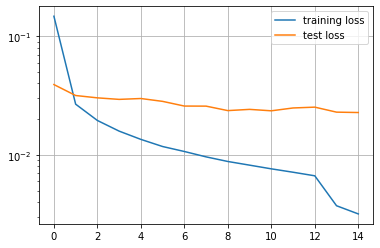

KeyboardInterrupt: 

In [6]:
best_loss = 1e3
last_save = 0
loss_arr = []
test_arr = []
for i in range(eps):
    m_e = []
    for x_train_batch, y_train_batch in data:
        x_train_gpu = x_train_batch.to(device)
        y_train_gpu = y_train_batch.to(device)
        y_pred = net(x_train_gpu)
        error = loss(y_pred, y_train_gpu) 
        m_e.append(error.cpu().detach().numpy())
        optimizer.zero_grad()
        error.backward()
        optimizer.step()
    
    m_error = np.mean(m_e)
    loss_arr.append(m_error)

    t_e = []
    for x_test_batch, y_test_batch in test:
        x_test_gpu = x_test_batch.to(device)
        y_test_gpu = y_test_batch.to(device)
        y_pred = net(x_test_gpu)
        error = loss(y_pred, y_test_gpu) 
        t_e.append(error.cpu().detach().numpy())
    
    t_error = np.mean(t_e)
    test_arr.append(t_error)

    #plotting
    plt.plot(loss_arr, label = "training loss")
    plt.plot(test_arr, label = "test loss")

    plt.yscale("log")
    plt.grid()
    plt.legend()
    clear_output(wait=True)
    plt.show()
  
    print("The iteration number : " + str(i) + " The loss is :" + str(m_error) + \
                          " Last save :"  + str(last_save), end='\r', flush  = True)    
    
    
    if best_loss > m_error:
        last_save = i
        torch.save(net.state_dict(), "./models/" + net_name)
        best_loss = m_error
    if i == 12:
        optimizer = torch.optim.Adam(net.parameters(), lr=lr/10)
    if i == 70:
        optimizer = torch.optim.Adam(net.parameters(), lr=lr/20)

        
torch.save(net.state_dict(), "./models/" + net_name)   

In [7]:
net = C_Net()
net.load_state_dict(torch.load("./models/cnn4", map_location=torch.device('cpu')))
mean = np.array([0.2738, 0.1354, 0.4108])
std = np.array([0.1312, 0.2271, 0.1631])
indices = [1,2,3,4,5,6,7,8,9]
dl = BoxDataSet(indices, mean = mean, std = std, rgbd = True, resize = (224,224))

using given mean


[0.4557249  0.23349972 0.21921238] [[0.44493573 0.22735336 0.2146929 ]] 0.0027542806961807914


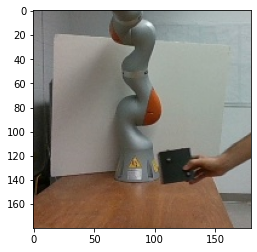

In [9]:
with torch.no_grad():
    image, label = dl.get_data(np.random.randint(10000))
    pred = net(image)
    l = loss(label.unsqueeze(0), pred)
    print((label*std + mean).numpy(), (pred*std+mean).numpy(), l.numpy())
    box = ToPILImage()(image[0][0:3])
    plt.imshow(box)

In [ ]:
data = np.load("./position_data/data" + str(17) + ".npz")
data = data["position"]
for i in range(len(data)):
    if np.linalg.norm(data[i]) == 0:
        print(i)

In [ ]:
len(data)